In [1]:
%matplotlib inline
import networkx as nx

## 木のパターン・マッチング

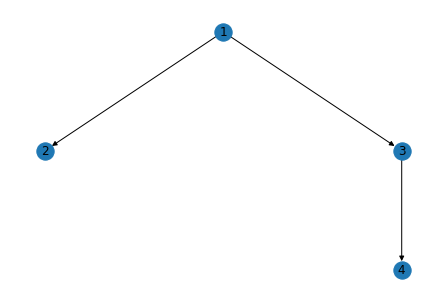

In [2]:
# 有向木
G = nx.DiGraph()
G.add_nodes_from(['1', '2', '3', '4'])
G.add_edges_from([('1', '2'), ('1', '3'), ('3', '4')])
posG = {'1': (10, 10), \
        '2': (5, 5), \
        '3': (15, 5), \
        '4': (15, 0)}
nx.draw(G, pos=posG, with_labels=True)

In [3]:
nx.is_arborescence(G)

True

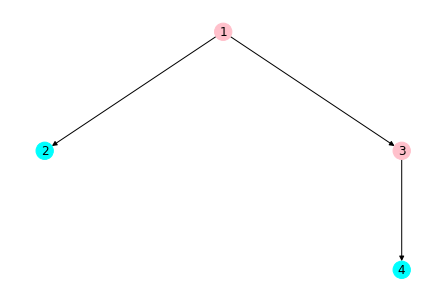

In [4]:
# 色付き有向木
colG = {'1': 'pink', \
        '2': 'cyan', \
        '3': 'pink', \
        '4': 'cyan'}
nx.draw(G, pos=posG, node_color = [colG[v] for v in G.nodes], with_labels=True)

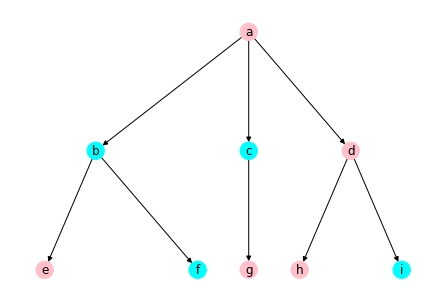

In [5]:
H = nx.DiGraph()
H.add_nodes_from(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'])
H.add_edges_from([('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'e'), ('b', 'f'), ('c', 'g'), ('d', 'h'), ('d', 'i')])
posH = {'a': (20, 10), \
        'b': (5, 5), \
        'c': (20, 5), \
        'd': (30, 5), \
        'e': (0,0), \
        'f': (15,0), \
        'g': (20,0), \
        'h': (25,0), \
        'i': (35,0)}
colH = {'a': 'pink', \
        'b': 'cyan', \
        'c': 'cyan', \
        'd': 'pink', \
        'e': 'pink', \
        'f': 'cyan', \
        'g': 'pink', \
        'h': 'pink', \
        'i': 'cyan'}
nx.draw(H, pos=posH, node_color = [colH[v] for v in H.nodes], with_labels=True)

In [6]:
nx.is_arborescence(H)

True

In [7]:
# 木のパターン・マッチング アルゴリズム
def root(arborescence):
    for (v, d) in arborescence.in_degree:
        if d == 0: r = v
    return r
    
def tree_match(guest_tree, host_tree, guest_coloring, host_coloring):
    r_guest = root(guest_tree)
    r_host = root(host_tree)
    nodelist_guest = list(nx.dfs_postorder_nodes(guest_tree, r_guest))
    nodelist_host = list(nx.dfs_postorder_nodes(host_tree, r_host))
    t = {}
    for u in nodelist_guest:
        for v in nodelist_host:
            t[(u, v)] = True
            if guest_coloring[u] != host_coloring[v]:
                t[(u, v)] = False
            else:
                graph = nx.Graph()
                graph.add_nodes_from(guest_tree.neighbors(u))
                graph.add_nodes_from(host_tree.neighbors(v))
                for u0 in guest_tree.neighbors(u):
                    for v0 in host_tree.neighbors(v):
                        if t[(u0, v0)] == True:
                            graph.add_edge(u0, v0)
                m = nx.max_weight_matching(graph)  # <-- compute a maximum matching
#                print(m)
                if len(m) == guest_tree.out_degree(u):
                    t[(u, v)] = True
                else:
                    t[(u, v)] = False
    print(t)
    u = nodelist_guest[-1]
    for v in nodelist_host:
        if t[(u, v)] == True:
            return True
    return False

In [8]:
tree_match(G, H, colG, colH)

{('2', 'e'): False, ('2', 'f'): True, ('2', 'b'): True, ('2', 'g'): False, ('2', 'c'): True, ('2', 'h'): False, ('2', 'i'): True, ('2', 'd'): False, ('2', 'a'): False, ('4', 'e'): False, ('4', 'f'): True, ('4', 'b'): True, ('4', 'g'): False, ('4', 'c'): True, ('4', 'h'): False, ('4', 'i'): True, ('4', 'd'): False, ('4', 'a'): False, ('3', 'e'): False, ('3', 'f'): False, ('3', 'b'): False, ('3', 'g'): False, ('3', 'c'): False, ('3', 'h'): False, ('3', 'i'): False, ('3', 'd'): True, ('3', 'a'): True, ('1', 'e'): False, ('1', 'f'): False, ('1', 'b'): False, ('1', 'g'): False, ('1', 'c'): False, ('1', 'h'): False, ('1', 'i'): False, ('1', 'd'): False, ('1', 'a'): True}


True

## ドナー交換腎移植

In [9]:
# cvxpy と numpy を使用する
import cvxpy as cp
import numpy as np

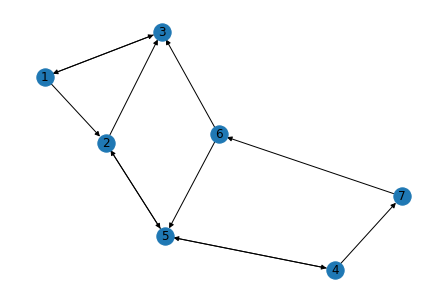

In [10]:
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7])
G.add_edges_from([[1, 2], [1, 3], [2, 3], [2, 5], [3, 1], [4, 5], [4, 7], [5, 2], [5, 4], [6, 3], [6, 5], [7, 6]])
nx.draw(G, with_labels = True)

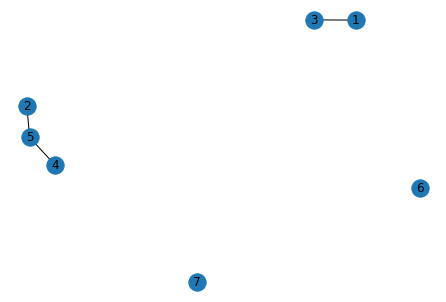

In [11]:
G0 = nx.Graph()
G0.add_nodes_from(G.nodes)
G0.add_edges_from([[u, v] for [u, v] in G.edges if [v, u] in G.edges])
nx.draw(G0, with_labels=True)

In [12]:
nx.max_weight_matching(G0)

{(1, 3), (2, 5)}

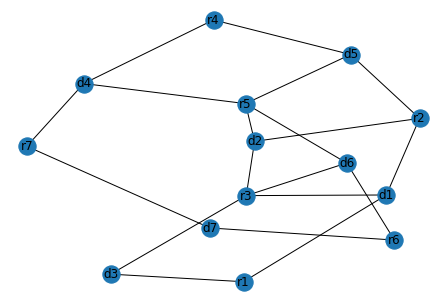

In [13]:
G1 = nx.Graph()
G1.add_nodes_from(['d'+str(v) for v in G.nodes])
G1.add_nodes_from(['r'+str(v) for v in G.nodes])
G1.add_edges_from([['d'+str(u), 'r'+str(v)] for [u, v] in G.edges], weight = 2)
G1.add_edges_from([['d'+str(v), 'r'+str(v)] for v in G.nodes], weight = 1)
nx.draw(G1, with_labels=True)

In [14]:
nx.max_weight_matching(G1)

{('d1', 'r2'),
 ('d4', 'r7'),
 ('d6', 'r3'),
 ('d7', 'r6'),
 ('r1', 'd3'),
 ('r4', 'd5'),
 ('r5', 'd2')}

In [15]:
# cvxpy と numpy を使用
def solve_kidney_exchange(graph, maxlen):
    n = graph.number_of_nodes()
    node_list = list(graph.nodes)
    cycle_list = []
    for c in nx.simple_cycles(G):
        if len(c) <= maxlen:
            cycle_list.append(c)
    m = len(cycle_list)
    x = cp.Variable(m, boolean=True)
    A = np.zeros(n*m)
    A.shape= (n, m)
    for i in range(m):
        for j in range(n):
            if node_list[j] in cycle_list[i]:
                A[j][i] = 1
    b = np.ones(n)
    c = np.ones(m)
    for i in range(m):
        c[i] = len(cycle_list[i])
    prob = cp.Problem(cp.Maximize(c.T@x), [A @ x <= b])
    prob.solve()
    print(maxlen, ":", prob.value)
#    print(x.value)
    return prob

In [16]:
for i in range(2, G.number_of_nodes()+1):
    solve_kidney_exchange(G, i)

2 : 4.0
3 : 5.0
4 : 7.0
5 : 7.0
6 : 7.0
7 : 7.0


In [17]:
# ランダムな有向グラフの生成
G = nx.random_k_out_graph(50, 1, 1.0, self_loops = False)
G.add_edges_from([[i, i+1] for i in range(G.number_of_nodes()-1) if not ([i,i+1] in G.edges) ])
G.add_edge(G.number_of_nodes()-1, 0)

0

99

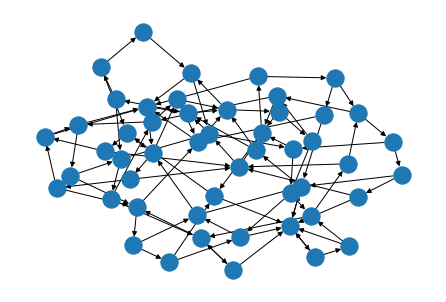

In [18]:
nx.draw_kamada_kawai(G)
G.number_of_edges()

In [19]:
# Execution takes some time
for i in range(2, G.number_of_nodes()+1):
    solve_kidney_exchange(G, i)

2 : 4.0
3 : 5.0
4 : 13.0
5 : 24.0
6 : 34.0
7 : 36.0
8 : 41.0
9 : 44.0
10 : 46.0
11 : 46.0
12 : 48.0
13 : 48.0
14 : 48.0
15 : 48.0
16 : 48.0
17 : 48.0
18 : 48.0
19 : 48.0
20 : 48.0
21 : 48.0
22 : 49.0
23 : 49.0
24 : 49.0
25 : 49.0
26 : 49.0
27 : 49.0
28 : 49.0
29 : 49.0
30 : 49.0
31 : 49.0
32 : 50.0
33 : 50.0
34 : 50.0
35 : 50.0
36 : 50.0
37 : 50.0
38 : 50.0
39 : 50.0
40 : 50.0
41 : 50.0
42 : 50.0
43 : 50.0
44 : 50.0
45 : 50.0
46 : 50.0
47 : 50.0
48 : 50.0
49 : 50.0
50 : 50.0


## 臨床研修病院選考

In [20]:
residents = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']
hospitals = ['h1', 'h2', 'h3', 'h4']
quota = {'h1' : 2, 'h2' : 2, 'h3' : 2, 'h4' : 2}
residents_preferences = { 'r1' : ['h2'],
                          'r2' : ['h2', 'h1'],
                          'r3' : ['h2', 'h1'],
                          'r4' : ['h1', 'h2', 'h3', 'h4'],
                          'r5' : ['h2', 'h1', 'h4', 'h3'],
                          'r6' : ['h2', 'h3', 'h1', 'h4'],
                          'r7' : ['h2', 'h1', 'h4', 'h3'],
                          'r8' : ['h4', 'h2', 'h1', 'h3']}
hospitals_preferences = { 'h1' : ['r3', 'r7'],
                          'h2' : ['r7', 'r8', 'r5', 'r1', 'r2', 'r3', 'r4', 'r6'],
                          'h3' : ['r2', 'r5', 'r8', 'r1', 'r3', 'r4', 'r7'],
                          'h4' : ['r2', 'r5', 'r1', 'r3', 'r6', 'r4', 'r7']}

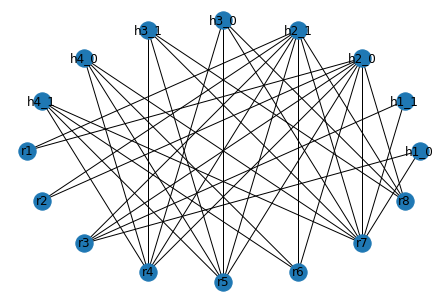

In [21]:
G = nx.Graph()
G.add_nodes_from(residents)
for h in hospitals:
    for i in range(quota[h]):
        G.add_node(h + '_' + str(i))
for r in residents:
    for h in hospitals:
        if r in hospitals_preferences[h] and h in residents_preferences[r]:
            w = (len(residents) - hospitals_preferences[h].index(r)) + (len(hospitals) - residents_preferences[r].index(h))
            for i in range(quota[h]):
                G.add_edge(r, h + '_' + str(i), weight=w)
nx.draw_shell(G, with_labels = True)

In [22]:
nx.max_weight_matching(G)

{('h1_0', 'r3'),
 ('h3_1', 'r4'),
 ('h4_1', 'r6'),
 ('r1', 'h2_1'),
 ('r2', 'h2_0'),
 ('r5', 'h4_0'),
 ('r7', 'h1_1'),
 ('r8', 'h3_0')}

In [23]:
men = ['m1', 'm2', 'm3', 'm4']
women = ['w1', 'w2', 'w3', 'w4']
men_preferences = {'m1' : ['w2', 'w1', 'w3', 'w4'],
                   'm2' : ['w4', 'w1', 'w2', 'w3'],
                   'm3' : ['w1', 'w3', 'w2', 'w4'],
                   'm4' : ['w2', 'w3', 'w1', 'w4']}
women_preferences = {'w1' : ['m1', 'm3', 'm2', 'm4'],
                     'w2' : ['m3', 'm4', 'm1', 'm2'],
                     'w3' : ['m4', 'm2', 'm3', 'm1'],
                     'w4' : ['m3', 'm2', 'm1', 'm4']}

In [24]:
list(men_preferences.keys())

['m1', 'm2', 'm3', 'm4']

In [25]:
def deferred_acceptance(m_pref, w_pref):
    # assumes preferences are complete
    m = list(m_pref.keys())
    w = list(w_pref.keys())
    m_engaged = {}
    w_engaged = {}
    m_index = {}
    w_index = {}
    m_free = []
    for i in m_pref.keys():
        m_engaged[i] = False
        m_index[i] = 0
        m_free.append(i)
    for j in w_pref.keys():
        w_engaged[j] = False
        w_index[j] = len(m)+1
    while len(m_free) != 0:
        i = m_free[0]
        j = m_pref[i][m_index[i]]
        if w_engaged[j] == False:
            m_engaged[i] = j
            w_engaged[j] = i
            del(m_free[0])
        else:
            k = w_engaged[j]
            index_i = w_pref[j].index(i)
            index_k = w_pref[j].index(k)
            if index_k < index_i:
                m_index[i] += 1
                if m_index[i] > len(w):
                    del(m_free[0])
            else:
                m_engaged[i] = j
                w_engaged[j] = i
                m_engaged[k] = False
                del(m_free[0])
                m_free.append(k)
                m_index[k] += 1
                if m_index[k] > len(w):
                    del(m_free[-1])
    return m_engaged

In [26]:
sm = deferred_acceptance(men_preferences, women_preferences)
print(sm)

{'m1': 'w1', 'm2': 'w4', 'm3': 'w3', 'm4': 'w2'}


In [27]:
def is_stable_matching(m_pref, w_pref, matching):
    # assumes preferences are complete and the matching is perfect
    m = list(m_pref.keys())
    w = list(w_pref.keys())
    inv_matching = {v: k for k, v in matching.items()}
    for i in m:
        for j in w:
            j0 = matching[i]
            i0 = inv_matching[j]
            index_i = w_pref[j].index(i)
            index_i0 = w_pref[j].index(i0)
            index_j = m_pref[i].index(j)
            index_j0 = m_pref[i].index(j0)
            if index_i < index_i0 and index_j < index_j0:
                print("a blocking pair found:", i, j)
                return False
    return True

In [28]:
is_stable_matching(men_preferences, women_preferences, sm)

True

In [29]:
m2 = {'m1' : 'w1', 'm2' : 'w2', 'm3' : 'w3', 'm4' : 'w4'}

In [30]:
is_stable_matching(men_preferences, women_preferences, m2)

a blocking pair found: m1 w2


False